In [1]:
import sys
sys.path.insert(1, 'C:/Users/raena/Documents/Imperial College London/msc_thesis/code/functions_and_classes')

from dataRead import *
from glob import glob
import pandas as pd
import numpy as np

## Index Period 1

Backtest:
* Jan 1999 - Dec 2004
* Major event: Dot-com bubble

In [2]:
# Get DJI Index weights data per quarter

DJI_weights_paths = glob('../../data/dataBBG/DJI_index_weights/DJI_*.pickle')
DJI_weights_per_quarter = {}
for path in DJI_weights_paths:
    date = path.split('.')[-2].split('_')[-1]
    DJI_weights_per_quarter[date] = pd.read_pickle(path)

# Import price and volume data for each stock in the DJI Index
DJI_PX_LAST_paths = glob('../../data/dataBBG/DJI_stock_PX_LAST/* Equity.pickle')
DJI_PX_VOLUME_paths = glob('../../data/dataBBG/DJI_stock_PX_VOLUME/* Equity.pickle')

DJI_price_data = {}
DJI_volume_data = {}

for path in DJI_PX_LAST_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    # if ticker == '3277Q UN': # JP Morgan
    #     path = '../../data/dataBBG/DJI_stock_PX_LAST/JPM UN Equity.pickle'
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    DJI_price_data[ticker] = df

for path in DJI_PX_VOLUME_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    # df.index = pd.to_datetime(df.index)
    DJI_volume_data[ticker] = df

trading_days = pd.to_datetime(list(DJI_price_data['AAPL'].index))

In [3]:
start_day = '1999-01-01'
end_day = '2004-12-31'
start_day_count = np.where(trading_days >= start_day)[0][0]
end_day_count = np.where(trading_days <= end_day)[0][-1]

TARGET_STAND_DEV = 0.10

# Validation

The validation period is the <b>first two years</b>.

The grid options are:
* return threshold: $c_r \in \{0.5,0.7, 0.9, 1.2\}$
* volume threshold: $c_v \in \{0.5, 0.7, 0.9, 1.2\}$ 
* lookback window size: $k = 252$

In [4]:
returnThresholdOptions = [0.3, 0.5, 0.7, 0.9]
volumeThresholdOptions = [-0.5, -0.3, 0, 0.3, 0.5]
windowOptions = [252]

validation_start_day = start_day
validation_end_day = '2000-12-31'
validation_start_day_count = start_day_count
validation_end_day_count = np.where(trading_days <= validation_end_day)[0][-1]

In [5]:
from priceVolumeIndexStrategy import *

validationResultsDict = {}
sharpeRatioResults = {'GS1' : {}, 'GS2': {}}

for windowSize in windowOptions:
    # 63, 126, 252
    start = validation_start_day_count - (windowSize + 1)
    end = validation_end_day_count
    trading_days_subset = trading_days[start:end]
    
    for cR in returnThresholdOptions:
        for cV in volumeThresholdOptions:
            key = str(cR) + '_' + str(cV) + '_' + str(windowSize)
            print(key)
            sInst = PriceVolumeIndexStrategy(
                        indexDict = DJI_weights_per_quarter,
                        trading_days = trading_days_subset,
                        priceDict = DJI_price_data,    
                        volumeDict = DJI_volume_data,
                        lookbackWindow = windowSize,
                        factor = 252.0)
            sInst = sInst.getStrategyWeights(
                methods = ['GS1','GS2'],
                thresholdmethod = 'standard_deviation',
                thresholdvalues = {'GS1': {'returns' : cR, 'volume': cV}, 
                                   'GS2': {'returns' : cR, 'volume': cV}},
                targetStandDev = TARGET_STAND_DEV)

            b = sInst.backtestStrategy()
            
            methodList = ['GS1', 'GS2']
            methodDict = {'Portfolio Returns': {}, 'Portfolio Value': {}, 'Volume Bought': {}, 'Volume Sold' : {}}
            for method in methodList:
                methodDict['Portfolio Returns'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Portfolio Returns']
                methodDict['Portfolio Value'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Portfolio Value']
                methodDict['Volume Bought'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Volume Bought']
                methodDict['Volume Sold'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Volume Sold']

            validationResultsDict[key] = methodDict

            for method in methodList:
                meth = method
                retS = methodDict['Portfolio Returns'][meth]
                dateIndex = trading_days_subset[-retS.shape[0]:]
                retS.index = dateIndex
                valS = methodDict['Portfolio Value'][meth]
                valS.index = dateIndex
                volBS = methodDict['Volume Bought'][meth]
                volBS.index = dateIndex
                volSS = methodDict['Volume Sold'][meth]
                volSS.index = dateIndex

                from performanceAnalysis import *
                perfInst = PerformanceAnalysis(portfolioReturns = retS,
                                            portfolioValue = valS,
                                            volBought = volBS,
                                            volSold = volSS,
                                            factor = 252.0)
                sharpeRatioResults[method][key] = perfInst.sharpeRatio()

            print('\n')

C:\Users\raena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.3_-0.5_252


100%|██████████| 502/502 [00:07<00:00, 67.04it/s]




0.3_-0.3_252


100%|██████████| 502/502 [00:07<00:00, 64.76it/s]




0.3_0_252


100%|██████████| 502/502 [00:07<00:00, 69.01it/s]




0.3_0.3_252


100%|██████████| 502/502 [00:05<00:00, 95.43it/s] 




0.3_0.5_252


100%|██████████| 502/502 [00:05<00:00, 92.26it/s]




0.5_-0.5_252


100%|██████████| 502/502 [00:05<00:00, 89.79it/s]




0.5_-0.3_252


100%|██████████| 502/502 [00:04<00:00, 105.90it/s]




0.5_0_252


100%|██████████| 502/502 [00:04<00:00, 110.52it/s]




0.5_0.3_252


100%|██████████| 502/502 [00:04<00:00, 109.93it/s]




0.5_0.5_252


100%|██████████| 502/502 [00:04<00:00, 107.84it/s]




0.7_-0.5_252


100%|██████████| 502/502 [00:04<00:00, 107.82it/s]




0.7_-0.3_252


100%|██████████| 502/502 [00:04<00:00, 113.66it/s]




0.7_0_252


100%|██████████| 502/502 [00:04<00:00, 104.73it/s]




0.7_0.3_252


100%|██████████| 502/502 [00:04<00:00, 110.40it/s]




0.7_0.5_252


100%|██████████| 502/502 [00:04<00:00, 110.59it/s]




0.9_-0.5_252


100%|██████████| 502/502 [00:07<00:00, 68.48it/s]




0.9_-0.3_252


100%|██████████| 502/502 [00:07<00:00, 66.77it/s]




0.9_0_252


100%|██████████| 502/502 [00:07<00:00, 65.83it/s]




0.9_0.3_252


100%|██████████| 502/502 [00:05<00:00, 96.78it/s] 




0.9_0.5_252


100%|██████████| 502/502 [00:04<00:00, 108.10it/s]

In [6]:
backup1 = validationResultsDict
backup2 = sharpeRatioResults

In [7]:
fp = '../../code/validation_period_results/backtest_results'
period = '1'+'_med_risk'
for key in validationResultsDict.keys():
    a = validationResultsDict[key]
    tempdf = pd.DataFrame.from_dict(a, orient = 'index').stack().to_frame()
    tempdf = pd.DataFrame(tempdf[0].values.tolist(), index = tempdf.index).T
    tempdf.to_pickle(f'{fp}/period_{period}/{key}.pickle')


fpSR = '../../code/validation_period_results/sharpe_ratio'
pd.DataFrame(sharpeRatioResults).to_pickle(f'{fpSR}/period_{period}.pickle')

max_SR_GS1 = pd.DataFrame(sharpeRatioResults).sort_values(by='GS1', ascending = False).iloc[0].name #GS1
max_SR_GS2 = pd.DataFrame(sharpeRatioResults).sort_values(by='GS2', ascending = False).iloc[0].name #GS1

In [8]:
from glob import glob
from priceVolumeIndexStrategy import *
fpSR = '../../code/validation_period_results/sharpe_ratio'
period = "1"+'_med_risk'
sr_fp_list = glob(f'{fpSR}/period_{period}.pickle')
sharpeRatioResults = pd.read_pickle(sr_fp_list[0])

max_SR_GS1 = sharpeRatioResults.sort_values(by='GS1', ascending = False).iloc[0].name #GS1
max_SR_GS2 = sharpeRatioResults.sort_values(by='GS2', ascending = False).iloc[0].name #GS1
print(max_SR_GS1)
print(max_SR_GS2)

0.3_0_252
0.3_0_252


# Test Period

Run every method, include the methods with the Gerber statistic hyperparameters that maximised the Sharpe Ratio in the validation period.

In [9]:
test_start_day = '2001-01-01'
test_end_day = end_day
test_start_day_count = np.where(trading_days >= test_start_day)[0][0]
test_end_day_count = np.where(trading_days <= test_end_day)[0][-1]
windowSize = 252
trading_days_test_subset = trading_days[test_start_day_count - (windowSize + 1):test_end_day_count]

cR1 = float(max_SR_GS1.split('_')[0])
cV1 = float(max_SR_GS1.split('_')[1])
cR2 = float(max_SR_GS2.split('_')[0])
cV2 = float(max_SR_GS2.split('_')[1])

methodList = ['HIS', 'GS1', 'GS2', 'LW', 'EQW']

sInst = PriceVolumeIndexStrategy(
            indexDict = DJI_weights_per_quarter,
            trading_days = trading_days_test_subset,
            priceDict = DJI_price_data,    
            volumeDict = DJI_volume_data,
            lookbackWindow = windowSize,
            factor = 252.0)
sInst = sInst.getStrategyWeights(
    methods = methodList,
    thresholdmethod = 'standard_deviation',
    thresholdvalues = {'GS1': {'returns' : cR1, 'volume': cV1}, 
                        'GS2': {'returns' : cR2, 'volume': cV2}},
    targetStandDev = TARGET_STAND_DEV)

b = sInst.backtestStrategy()

methodList = ['HIS', 'GS1', 'GS2', 'LW', 'EQW']
methodDict = {'Portfolio Returns': {}, 'Portfolio Value': {}, 'Volume Bought': {}, 'Volume Sold' : {}}
for method in methodList:
    methodDict['Portfolio Returns'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Portfolio Returns']
    methodDict['Portfolio Value'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Portfolio Value']
    methodDict['Volume Bought'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Volume Bought']
    methodDict['Volume Sold'][method] = pd.DataFrame([b[k][method] for k in b.keys()])['Volume Sold']

  0%|          | 0/1002 [00:00<?, ?it/s]

100%|██████████| 1002/1002 [00:26<00:00, 37.14it/s]


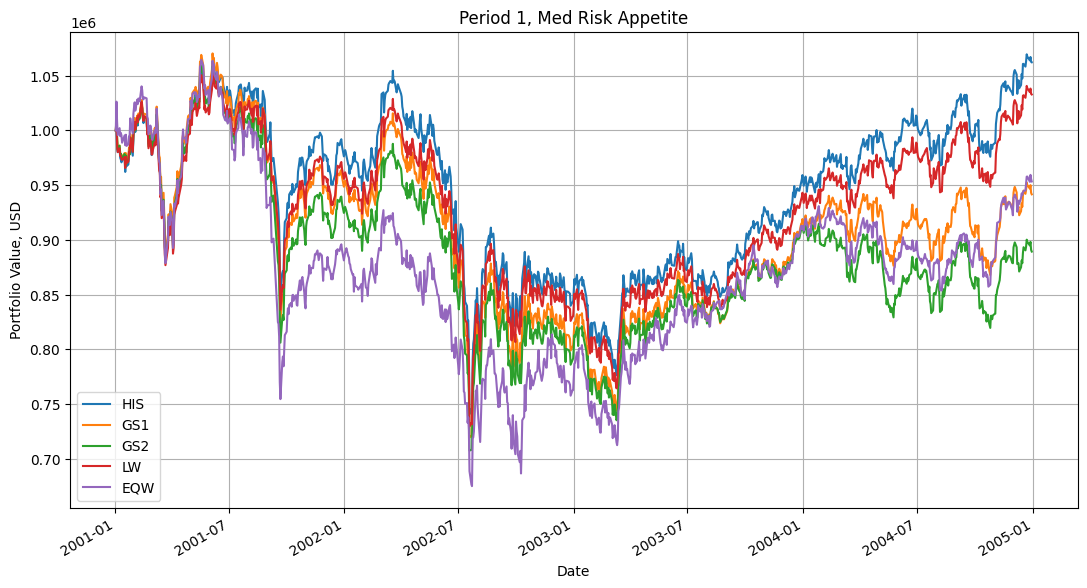

\begin{tabular}{l|rrrr}
\toprule
 & Annual. Returns & Annual. Stand. Dev & Annual. Skew & Annual. Kurtosis \
\midrule
HIS & 0.0152 & 0.1628 & -0.3587 & 8.9280 \\
LW & 0.0081 & 0.1626 & -0.2993 & 8.3881 \\
EQW & -0.0119 & 0.1852 & -0.2284 & 8.4848 \\
GS1 & -0.0149 & 0.1685 & -0.3351 & 7.9739 \\
GS2 & -0.0289 & 0.1700 & -0.3237 & 7.9363 \\
\midrule
& Total Returns & Arith. Returns & Geom. Returns & Sharpe Ratio \
\midrule
HIS & 0.0623 & 0.0212 & 0.0152 & 0.1748 \\
LW & 0.0328 & 0.0139 & 0.0081 & 0.1313 \\
EQW & -0.0466 & -0.0030 & -0.0119 & 0.0278 \\
GS1 & -0.0584 & -0.0090 & -0.0149 & -0.0056 \\
GS2 & -0.1107 & -0.0230 & -0.0289 & -0.0885 \\
\midrule
& Max. Drawdown & Annual. Turnover & VaR \
\midrule
HIS & -0.3027 & 4.4037 & -0.0161 \\
LW & -0.3064 & 4.1423 & -0.0162 \\
EQW & -0.3660 & 0.9741 & -0.0179 \\
GS1 & -0.3279 & 5.8727 & -0.0169 \\
GS2 & -0.3322 & 5.1602 & -0.0168 \\
\bottomrule
\end{tabular}


In [23]:
df = pd.DataFrame(methodDict['Portfolio Value'])
df.index = pd.to_datetime(trading_days_test_subset[-df.shape[0] :], utc=True)

fpFig = '../../code/figures'

import matplotlib.pyplot as plt

plot = df.plot(figsize=(13,7))
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Portfolio Value, USD')
p1 = period.split('_')[0]
p2 = period.split('_')[1].capitalize()
plt.title(f'Period {p1}, {p2} Risk Appetite')
plt.savefig(f'{fpFig}/period_{period}.pdf', bbox_inches='tight')
plt.show()

meth_result_metrics = {}
from performanceAnalysis import *
for method in methodList:
    meth = method
    retS = methodDict['Portfolio Returns'][meth]
    dateIndex = trading_days_test_subset[-retS.shape[0]:]
    retS.index = dateIndex
    valS = methodDict['Portfolio Value'][meth]
    valS.index = dateIndex
    volBS = methodDict['Volume Bought'][meth]
    volBS.index = dateIndex
    volSS = methodDict['Volume Sold'][meth]
    volSS.index = dateIndex

    perfInst = PerformanceAnalysis(portfolioReturns = retS,
                                portfolioValue = valS,
                                volBought = volBS,
                                volSold = volSS,
                                factor = 252.0)
    meth_result_metrics[method] = perfInst.metricSeries(rf = 0)

perfRes = pd.DataFrame(meth_result_metrics).T.sort_values(by = 'Sharpe Ratio', ascending = False)
pRes1 = perfRes.iloc[:,0:4]
pRes2 = perfRes.iloc[:,4:8]
pRes3 = perfRes.iloc[:,8:]
pRes1 = pRes1.style.format(precision = 4)
print('\\begin{tabular}{l|rrrr}')
print('\\toprule')
print(' & Annual. Returns & Annual. Stand. Dev & Annual. Skew & Annual. Kurtosis \\\\')
print('\midrule')
print('\n'.join(str(pRes1.to_latex()).split('\n')[2:-2]))
print('\midrule')
pRes2 = pRes2.style.format(precision = 4)
print('& Total Returns & Arith. Returns & Geom. Returns & Sharpe Ratio \\\\')
print('\midrule')
print('\n'.join(str(pRes2.to_latex()).split('\n')[2:-2]))
print('\midrule')
pRes3 = pRes3.style.format(precision = 4)
print('& Max. Drawdown & Annual. Turnover & VaR \\\\')
print('\midrule')
print('\n'.join(str(pRes3.to_latex()).split('\n')[2:-2]))
print('\\bottomrule')
print('\end{tabular}')

In [11]:
meth_result_metrics = {}
from performanceAnalysis import *
for method in methodList:
    meth = method
    retS = methodDict['Portfolio Returns'][meth]
    dateIndex = trading_days_test_subset[-retS.shape[0]:]
    retS.index = dateIndex
    valS = methodDict['Portfolio Value'][meth]
    valS.index = dateIndex
    volBS = methodDict['Volume Bought'][meth]
    volBS.index = dateIndex
    volSS = methodDict['Volume Sold'][meth]
    volSS.index = dateIndex

    perfInst = PerformanceAnalysis(portfolioReturns = retS,
                                portfolioValue = valS,
                                volBought = volBS,
                                volSold = volSS,
                                factor = 252.0)
    meth_result_metrics[method] = perfInst.metricSeries(rf = 0)

perfRes = pd.DataFrame(meth_result_metrics).T.sort_values(by = 'Sharpe Ratio', ascending = False)
pRes1 = perfRes.iloc[:,0:4]
pRes2 = perfRes.iloc[:,4:8]
pRes3 = perfRes.iloc[:,8:]
pRes1 = pRes1.style.format(precision = 4)
print('\n'.join(str(pRes1.to_latex()).split('\n')[:-2]))
pRes2 = pRes2.style.format(precision = 4)
print('\n'.join(str(pRes2.to_latex()).split('\n')[1:-2]))
pRes3 = pRes3.style.format(precision = 4)
print('\n'.join(str(pRes3.to_latex()).split('\n')[1:]))

\begin{tabular}{lrrrr}
 & Annual. Returns & Annual. Stand. Dev & Annual. Skew & Annual. Kurtosis \\
HIS & 0.0152 & 0.1628 & -0.3587 & 8.9280 \\
LW & 0.0081 & 0.1626 & -0.2993 & 8.3881 \\
EQW & -0.0119 & 0.1852 & -0.2284 & 8.4848 \\
GS1 & -0.0149 & 0.1685 & -0.3351 & 7.9739 \\
GS2 & -0.0289 & 0.1700 & -0.3237 & 7.9363 \\
 & Total Returns & Arith. Returns & Geom. Returns & Sharpe Ratio \\
HIS & 0.0623 & 0.0212 & 0.0152 & 0.1748 \\
LW & 0.0328 & 0.0139 & 0.0081 & 0.1313 \\
EQW & -0.0466 & -0.0030 & -0.0119 & 0.0278 \\
GS1 & -0.0584 & -0.0090 & -0.0149 & -0.0056 \\
GS2 & -0.1107 & -0.0230 & -0.0289 & -0.0885 \\
 & Max. Drawdown & Annual. Turnover & VaR \\
HIS & -0.3027 & 4.4037 & -0.0161 \\
LW & -0.3064 & 4.1423 & -0.0162 \\
EQW & -0.3660 & 0.9741 & -0.0179 \\
GS1 & -0.3279 & 5.8727 & -0.0169 \\
GS2 & -0.3322 & 5.1602 & -0.0168 \\
\end{tabular}



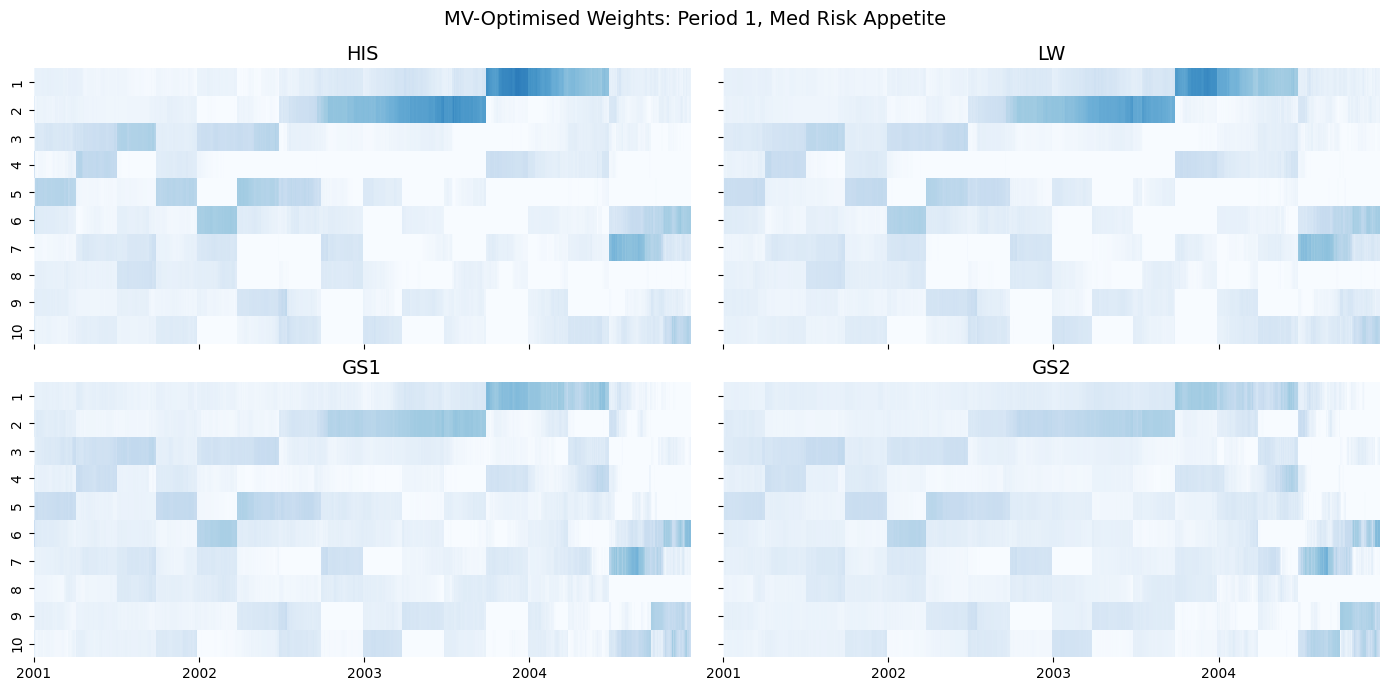

In [12]:
weights = sInst.weights
tList = weights.keys()

methods = ['HIS', 'LW', 'GS1', 'GS2']
methodWeights = {meth: {} for meth in methods}
for t in tList:
    for meth in methods:
        methodWeights[meth][t] = weights[t][meth].values()

import seaborn as sns
import matplotlib.ticker as ticker

def corr_heatmap(heatmap1, 
                ax,
                method = 'HIS',
                vmin = 0,
                vmax = 1,
                cmap = 'Blues'):
    sns.heatmap(heatmap1, cmap = cmap, vmin = vmin, vmax = vmax, cbar=False, ax = ax,
                    xticklabels = 252)
    ax.set_yticks(np.arange(heatmap1.shape[0]) + 0.5, labels=np.arange(heatmap1.shape[0])+1)
    title = f"{meth}"
    ax.set_title(title, fontsize = 14)
    return fig, ax

fpFig = '../../code/figures'
fig, ax = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey=True)
ax = ax.reshape(-1)
axislabels = pd.to_datetime(trading_days_test_subset[-df.shape[0] :], utc=True).date
axislabels = [str(a.year) for a in axislabels]
for i, meth in enumerate(methods):
    heatmap1 = pd.DataFrame(methodWeights[meth])
    heatmap1.columns = axislabels
    corr_heatmap(heatmap1, ax = ax[i], method = meth)
plt.suptitle(f'MV-Optimised Weights: Period {p1}, {p2} Risk Appetite', fontsize = 14)
fig.tight_layout()
plt.show()